*Ewing et al (2020) Structural variants at the BRCA1/2 loci are a common source of homologous repair deficiency in high grade serous ovarian carcinoma*

## Notebook 10 - Survival analysis

# Prepare and merge clinical data

## AOCS

In [2]:
aocs_clinical<-read.table("AOCS_clinical_neoantigen_info.csv",header=T,sep=",")

In [3]:
aocs_clinical_withdat<-aocs_clinical[aocs_clinical$specimen_type_description=="primary tumour",
                                       c("project_code","donor","icgc_donor_id","donor_age_at_diagnosis",
                                         "donor_tumour_stage_at_diagnosis","treatment","olaparib","donor_vital_status",
                                         "donor_survival_time","donor_interval_of_last_followup",
                                         "disease_status_last_followup","donor_relapse_interval")]

** Format survival endpoints**

In [4]:
aocs_clinical_withdat[aocs_clinical_withdat$donor_vital_status=="alive","os_event"]<-0
aocs_clinical_withdat[aocs_clinical_withdat$donor_vital_status=="deceased","os_event"]<-1

aocs_clinical_withdat[aocs_clinical_withdat$disease_status_last_followup=="complete remission","pfs_event"]<-0
aocs_clinical_withdat[aocs_clinical_withdat$disease_status_last_followup=="relapse","pfs_event"]<-1
aocs_clinical_withdat[aocs_clinical_withdat$disease_status_last_followup=="progression","pfs_event"]<-1

aocs_clinical_withdat[aocs_clinical_withdat$disease_status_last_followup=="progression","donor_relapse_interval"]<-0


**Format Neo-adjuvant chemo status**

In [5]:
aocs_clinical_withdat[aocs_clinical_withdat$treatment=="chemo treated","neoadjuvant"]<-1
aocs_clinical_withdat[aocs_clinical_withdat$treatment=="treatment naive","neoadjuvant"]<-0

**Format tumour stage at diagnosis**

In [6]:
aocs_clinical_withdat[aocs_clinical_withdat$donor_tumour_stage_at_diagnosis=="III","stage"]<-3
aocs_clinical_withdat[aocs_clinical_withdat$donor_tumour_stage_at_diagnosis=="IV","stage"]<-4

**Merge ids**

In [7]:
aocs_clinical_withdat$Sample<-gsub("-","_",as.character(aocs_clinical_withdat$donor))
rownames(aocs_clinical_withdat)<-as.character(aocs_clinical_withdat$Sample)

In [8]:
ids<-read.table("AOCS_usable_ids.txt",sep="\t")
ids<-as.character(ids[,1])

In [9]:
pcawg_clinical_withdat_aocs<-aocs_clinical_withdat[ids,]

In [ ]:
pcawg_clinical_withdat_aocs<-pcawg_clinical_withdat_aocs[,c("Sample","donor_age_at_diagnosis","stage","neoadjuvant","donor_survival_time","os_event","donor_relapse_interval","pfs_event")]
pcawg_clinical_withdat_aocs$cohort<-"AOCS"

## TCGA

In [11]:
pcawg_clinical<-read.table("pcawg_ovca_clinical_230819.txt",header=T,sep="\t")
pcawg_clinical_withdat_tcga<-pcawg_clinical[pcawg_clinical$project_code=="OV-US",c("project_code","icgc_donor_id","donor_age_at_diagnosis","donor_vital_status","donor_survival_time","donor_interval_of_last_followup")]

In [12]:
pcawg_clinical_withdat_tcga$surv_time<-pcawg_clinical_withdat_tcga$donor_survival_time
pcawg_clinical_withdat_tcga[which(is.na(pcawg_clinical_withdat_tcga$donor_survival_time)),"surv_time"]<-pcawg_clinical_withdat_tcga[which(is.na(pcawg_clinical_withdat_tcga$donor_survival_time)),"donor_interval_of_last_followup"]

In [13]:
pcawg_clinical_withdat_tcga[pcawg_clinical_withdat_tcga$donor_vital_status=="alive","os_event"]<-0
pcawg_clinical_withdat_tcga[pcawg_clinical_withdat_tcga$donor_vital_status=="deceased","os_event"]<-1

In [14]:
pcawg_clinical_withdat_tcga$Sample<-pcawg_clinical_withdat_tcga$icgc_donor_id

In [15]:
tcga_stage<-read.table("tcga_stage_age.txt",header=T,sep="\t")
colnames(tcga_stage)[1]<-"Sample"
add_tcga<-merge(pcawg_clinical_withdat_tcga,tcga_stage,by="Sample",all.x=T)

In [16]:
add_tcga$neoadjuvant<-NA
add_tcga$donor_relapse_interval<-NA
add_tcga$pfs_event<-NA
pcawg_clinical_withdat_tcga<-add_tcga[,c("Sample","donor_age_at_diagnosis","stage","neoadjuvant","donor_survival_time",
                                        "os_event","donor_relapse_interval","pfs_event")]
pcawg_clinical_withdat_tcga$cohort<-"TCGA"

#Sample excluded late due to discovery of contaminated matched normal in TCGA
pcawg_clinical_withdat_tcga<-pcawg_clinical_withdat_tcga[pcawg_clinical_withdat_tcga$Sample!="DO30650",]


## SHGSOC

In [17]:
shgsoc_clinical<-read.csv("SHGSOC.clinical.EdGlasgowDundee.minimal.csv")

In [ ]:
shgsoc_clinical$Sample<-as.character(shgsoc_clinical$New_Patient_id)
shgsoc_clinical$cohort<-"SHGSOC"
shgsoc_clinical$donor_age_at_diagnosis<-shgsoc_clinical$AgeAtDiagnosis

shgsoc_clinical$stage<-NA
shgsoc_clinical[which(shgsoc_clinical$FIGO.stage=="III"),"stage"]<-3
shgsoc_clinical[which(shgsoc_clinical$FIGO.stage=="IV"),"stage"]<-4
shgsoc_clinical[which(shgsoc_clinical$FIGO.stage=="II"),"stage"]<-2
shgsoc_clinical[which(shgsoc_clinical$FIGO.stage=="I"),"stage"]<-1

shgsoc_clinical$donor_survival_time<-shgsoc_clinical$OS.days
shgsoc_clinical$os_event<-NA
shgsoc_clinical[shgsoc_clinical$OS.status=="deceased","os_event"]<-1
shgsoc_clinical[shgsoc_clinical$OS.status=="alive","os_event"]<-0

shgsoc_clinical$donor_relapse_interval<-shgsoc_clinical$radioPFS
shgsoc_clinical$pfs_event<-NA
shgsoc_clinical[which(shgsoc_clinical$radioPFS.status=="progressed"),"pfs_event"]<-1
shgsoc_clinical[which(shgsoc_clinical$radioPFS.status=="stable"),"pfs_event"]<-0

shgsoc_clinical<-shgsoc_clinical[,c("Sample","donor_age_at_diagnosis","stage","donor_survival_time","os_event","donor_relapse_interval","pfs_event","cohort")]

### Add neo-adjuvant

In [19]:
#Edinburgh
edinburgh_clin<-read.csv("Edinburgh_cohortA_ailith_clinical.csv")
edinburgh_clin$Sample<-as.character(edinburgh_clin$ailiths_ID)
edinburgh_clin$neoadjuvant<-NA
edinburgh_clin[edinburgh_clin$Neoadjuvant=="Yes","neoadjuvant"]<-1
edinburgh_clin[edinburgh_clin$Neoadjuvant=="No","neoadjuvant"]<-0
edinburgh_clin<-edinburgh_clin[,c("Sample","neoadjuvant")]

#Dundee
dundee_clin<-read.csv("Dundee_cohortA_ailith_clinical.csv")
dundee_clin$newneoadjuvant<-NA
dundee_clin[dundee_clin$neoadjuvant=="Yes","newneoadjuvant"]<-1
dundee_clin[dundee_clin$neoadjuvant=="no","newneoadjuvant"]<-0
dundee_clin$neoadjuvant<-dundee_clin$newneoadjuvant
dundee_clin<-dundee_clin[,c("Sample","neoadjuvant")]

#Glasgow
glasgow_clin<-read.csv("Glasgow_cohortA_ailith_clinical.csv")
glasgow_clin$Sample<-as.character(glasgow_clin$Sample.ID)
glasgow_clin$newneoadjuvant<-NA
glasgow_clin[glasgow_clin$Neoadvjuvent.Chemo=="Yes","newneoadjuvant"]<-1
glasgow_clin[glasgow_clin$Neoadvjuvent.Chemo=="no","newneoadjuvant"]<-0
glasgow_clin$neoadjuvant<-glasgow_clin$newneoadjuvant
glasgow_clin<-glasgow_clin[,c("Sample","neoadjuvant")]

all_neo<-rbind(edinburgh_clin,dundee_clin,glasgow_clin)

In [ ]:
shgsoc_clin_withneo<-merge(shgsoc_clinical,all_neo,by="Sample")
shgsoc_clin_withneo<-shgsoc_clin_withneo[,c("Sample","donor_age_at_diagnosis","stage","neoadjuvant","donor_survival_time","os_event","donor_relapse_interval","pfs_event","cohort")]

## Combine datasets

In [21]:
all_clin_dat<-rbind(pcawg_clinical_withdat_aocs,pcawg_clinical_withdat_tcga,shgsoc_clin_withneo)

### Merge with sample info

In [24]:
sampleInfo<-read.table("SampleInformation.txt",sep="\t",header=T,stringsAsFactors=F)
rownames(sampleInfo)<-sampleInfo[,1]
sampleInfo$HRDeficient<-ifelse(sampleInfo$HRDetect>0.7,1,0)

In [26]:
clinical_withdat_sampleinfo<-merge(all_clin_dat,sampleInfo,by="Sample",all.x=T)

# Modelling - all patients

## Overall survival analysis

### Model

In [28]:
library(survival)

In [ ]:
clinical_withdat_sampleinfo_keyvars<-clinical_withdat_sampleinfo[,c("Sample","donor_survival_time","os_event","HRDetect")]
clinical_withdat_sampleinfo_keyvars<-clinical_withdat_sampleinfo_keyvars[is.na(clinical_withdat_sampleinfo_keyvars$HRDetect)==FALSE,]

In [ ]:
clinical_withdat_sampleinfo$donor_survival_time<-as.numeric(clinical_withdat_sampleinfo$donor_survival_time)

In [31]:
mod<-coxph(Surv(clinical_withdat_sampleinfo$donor_survival_time,clinical_withdat_sampleinfo$os_event)~clinical_withdat_sampleinfo$HRDetect+strata(as.factor(clinical_withdat_sampleinfo$Cohort)))
mod_age_stage<-coxph(Surv(clinical_withdat_sampleinfo$donor_survival_time,clinical_withdat_sampleinfo$os_event)~clinical_withdat_sampleinfo$HRDetect+clinical_withdat_sampleinfo$donor_age_at_diagnosis+clinical_withdat_sampleinfo$stage+strata(as.factor(clinical_withdat_sampleinfo$Cohort)))
mod_binary_age_stage<-coxph(Surv(clinical_withdat_sampleinfo$donor_survival_time,clinical_withdat_sampleinfo$os_event)~as.factor(clinical_withdat_sampleinfo$HRDeficient)+clinical_withdat_sampleinfo$donor_age_at_diagnosis+clinical_withdat_sampleinfo$stage+strata(as.factor(clinical_withdat_sampleinfo$Cohort)))

In [ ]:
summary(mod)
summary(mod_age_stage)
summary(mod_binary_age_stage)

### Check assumptions

In [33]:
test.ph<-cox.zph(mod_age_stage)

In [ ]:
library(survminer)
test.ph
ggcoxzph(test.ph)
ggcoxdiagnostics(mod_age_stage, type = "deviance", linear.predictions = TRUE)

### Kaplan-Meier curves

In [37]:
censored<-clinical_withdat_sampleinfo
censored$event<-censored$os_event
censored$surv_time<-censored$donor_survival_time
censored[which(censored$donor_survival_time>2557),"event"]<-0
censored[which(censored$donor_survival_time>2557),"surv_time"]<-2557
fit_censored <- survfit(Surv(surv_time,event) ~ HRDeficient,data=censored)

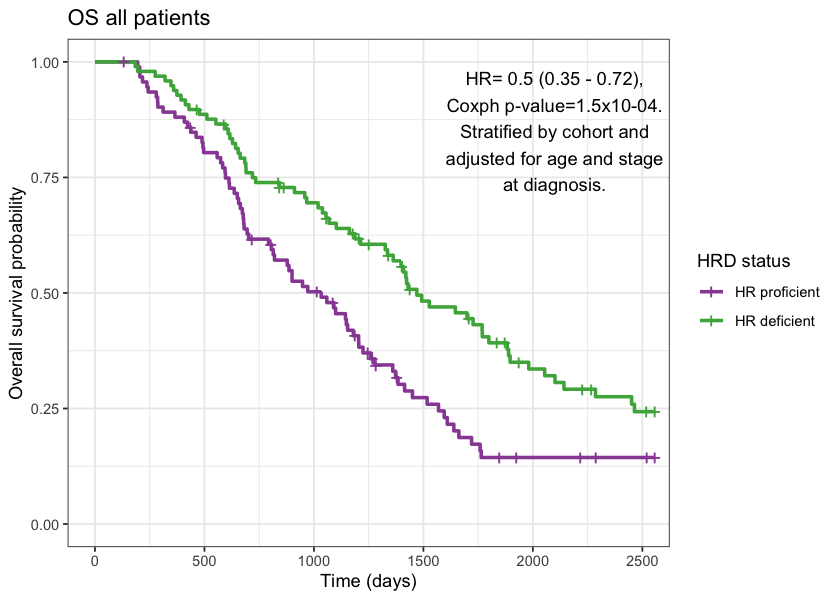

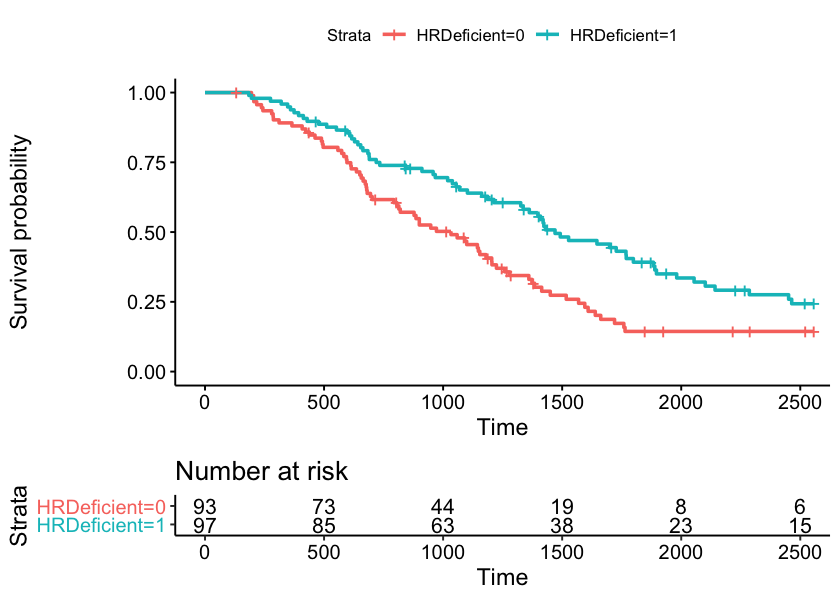

In [38]:
options(repr.plot.height=5,repr.plot.width=7)
gg1<-ggsurvplot(fit_censored,data=censored,risk.table=T)

options(repr.plot.height=5,repr.plot.width=7)

gg1_km<-gg1$plot + theme_bw()+
annotate("text",x=2100,y=0.85,
         label="HR= 0.5 (0.35 - 0.72),\nCoxph p-value=1.5x10-04.\nStratified by cohort and\nadjusted for age and stage\nat diagnosis.")+
xlab("Time (days)")+
scale_colour_manual(name="HRD status",values=c("#984EA3","#4DAF4A"),labels=c("HR proficient","HR deficient"))+
ylab("Overall survival probability")+
ggtitle("OS all patients")

gg1_km

print(gg1,surv.plot.height=0)

## Progression-free survival 

### Model

In [42]:
mod<-coxph(Surv(clinical_withdat_sampleinfo$donor_relapse_interval,clinical_withdat_sampleinfo$pfs_event)~clinical_withdat_sampleinfo$HRDetect+strata(as.factor(clinical_withdat_sampleinfo$cohort)))
mod_binary_age_stage<-coxph(Surv(clinical_withdat_sampleinfo$donor_relapse_interval,clinical_withdat_sampleinfo$pfs_event)~as.factor(clinical_withdat_sampleinfo$HRDeficient)+clinical_withdat_sampleinfo$donor_age_at_diagnosis+clinical_withdat_sampleinfo$stage+strata(as.factor(clinical_withdat_sampleinfo$cohort)))
mod_age_stage<-coxph(Surv(clinical_withdat_sampleinfo$donor_relapse_interval,clinical_withdat_sampleinfo$pfs_event)~clinical_withdat_sampleinfo$HRDetect+clinical_withdat_sampleinfo$donor_age_at_diagnosis+clinical_withdat_sampleinfo$stage+strata(as.factor(clinical_withdat_sampleinfo$cohort)))

In [ ]:
summary(mod)
summary(mod_binary_age_stage)
summary(mod_age_stage)

### Check assumptions

In [ ]:
test.ph<-cox.zph(mod_age_stage)
ggcoxzph(test.ph)

In [ ]:
ggcoxdiagnostics(mod_age_stage, type = "deviance", linear.predictions = TRUE)

### Kaplan-Meier curves

In [46]:
censored<-clinical_withdat_sampleinfo
censored$event<-censored$pfs_event
censored$surv_time<-censored$donor_relapse_interval
censored[which(censored$donor_relapse_interval>2557),"event"]<-0
censored[which(censored$donor_relapse_interval>2557),"surv_time"]<-2557
fit_censored <- survfit(Surv(surv_time,event) ~ HRDeficient,data=censored)

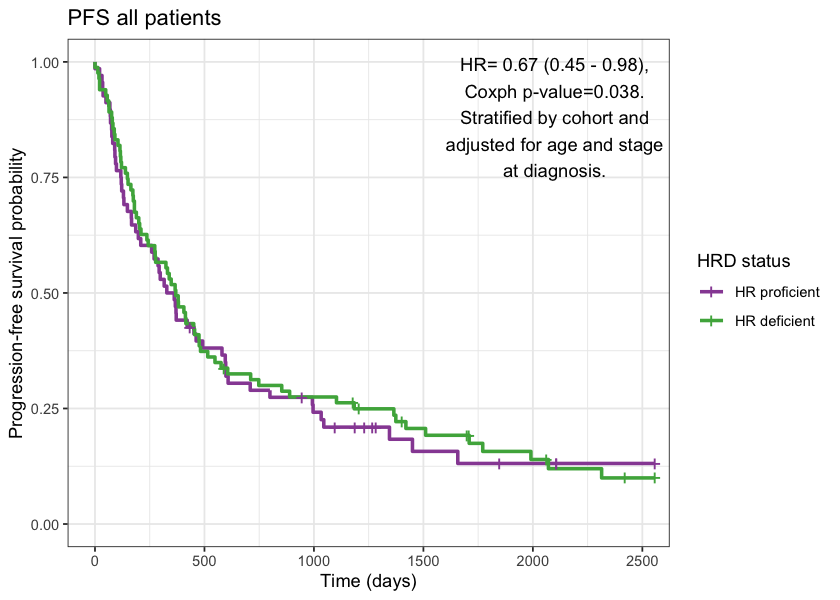

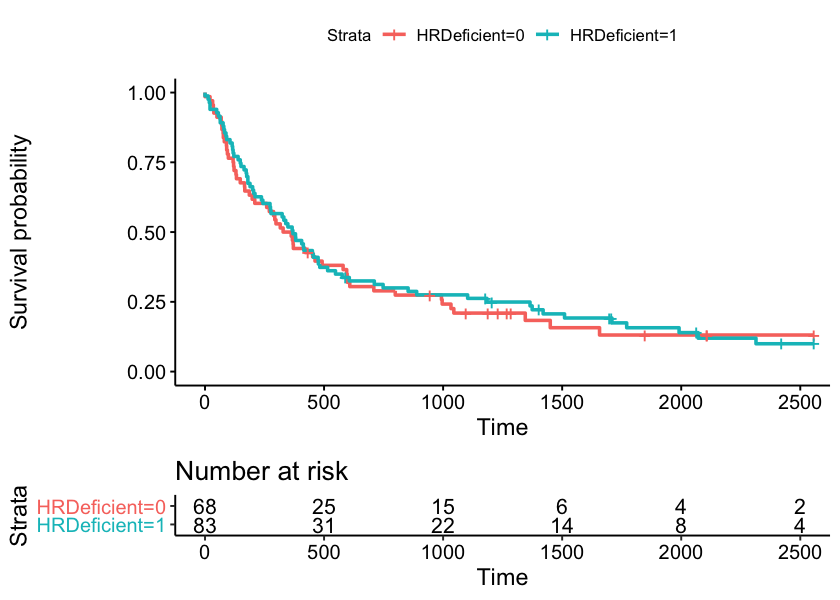

In [47]:
gg2<-ggsurvplot(fit_censored,data=censored,risk.table=T)

options(repr.plot.height=5,repr.plot.width=7)

gg2_km<-gg2$plot + theme_bw()+
annotate("text",x=2100,y=0.88,label="HR= 0.67 (0.45 - 0.98),\nCoxph p-value=0.038.\nStratified by cohort and\nadjusted for age and stage\nat diagnosis.")+
xlab("Time (days)")+
scale_colour_manual(name="HRD status",values=c("#984EA3","#4DAF4A"),labels=c("HR proficient","HR deficient"))+
ylab("Progression-free survival probability")+ggtitle("PFS all patients")

gg2_km
gg2

# Filter survival analysis to exclude patients with BRCA1/2 short variants

## Overall survival analysis

### Model

In [ ]:
clinical_withdat_sampleinfo_nobrca<-clinical_withdat_sampleinfo[clinical_withdat_sampleinfo$BRCAstatus!="Germline SNV" &
                                                               clinical_withdat_sampleinfo$BRCAstatus!="Somatic SNV",]

In [46]:
mod<-coxph(Surv(clinical_withdat_sampleinfo_nobrca$donor_survival_time,
                clinical_withdat_sampleinfo_nobrca$os_event)~clinical_withdat_sampleinfo_nobrca$HRDetect+
           strata(as.factor(clinical_withdat_sampleinfo_nobrca$Cohort)))

mod2<-coxph(Surv(clinical_withdat_sampleinfo_nobrca$donor_survival_time,
                 clinical_withdat_sampleinfo_nobrca$os_event)~as.factor(clinical_withdat_sampleinfo_nobrca$HRDeficient)+
           clinical_withdat_sampleinfo_nobrca$donor_age_at_diagnosis+
                     clinical_withdat_sampleinfo_nobrca$stage+
                     strata(as.factor(clinical_withdat_sampleinfo_nobrca$Cohort)))

mod_age_stage<-coxph(Surv(clinical_withdat_sampleinfo_nobrca$donor_survival_time,
                          clinical_withdat_sampleinfo_nobrca$os_event)~clinical_withdat_sampleinfo_nobrca$HRDetect+
                     clinical_withdat_sampleinfo_nobrca$donor_age_at_diagnosis+
                     clinical_withdat_sampleinfo_nobrca$stage+
                     strata(as.factor(clinical_withdat_sampleinfo_nobrca$Cohort)))

### Check assumptions

In [ ]:
summary(mod2)
summary(mod_age_stage)
test.ph<-cox.zph(mod_age_stage)
test.ph
ggcoxzph(test.ph)
ggcoxdiagnostics(mod_age_stage, type = "deviance", linear.predictions = TRUE)

In [48]:
censored<-clinical_withdat_sampleinfo_nobrca
censored$event<-censored$os_event
censored$surv_time<-censored$donor_survival_time
censored[which(censored$donor_survival_time>2557),"event"]<-0
censored[which(censored$donor_survival_time>2557),"surv_time"]<-2557
fit_censored <- survfit(Surv(surv_time,event) ~ HRDeficient,data=censored)

### Kaplan-Meier curves

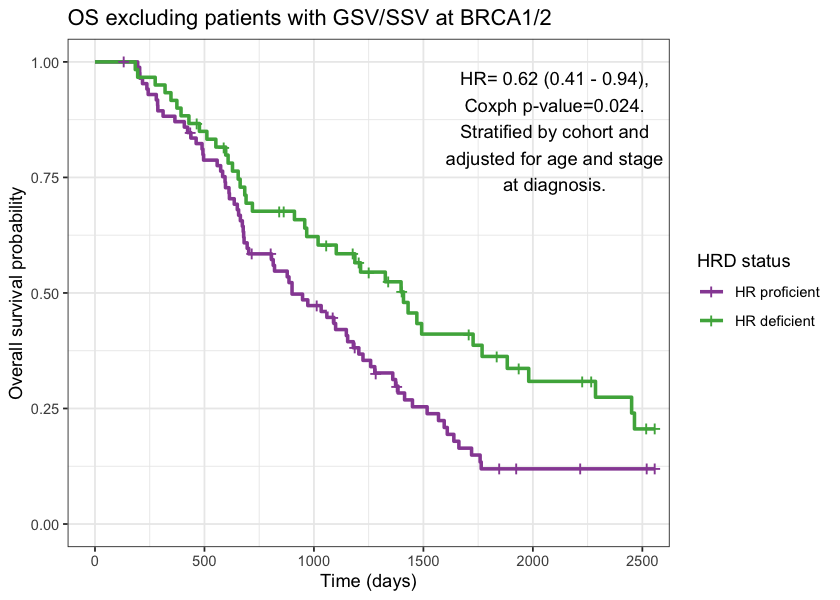

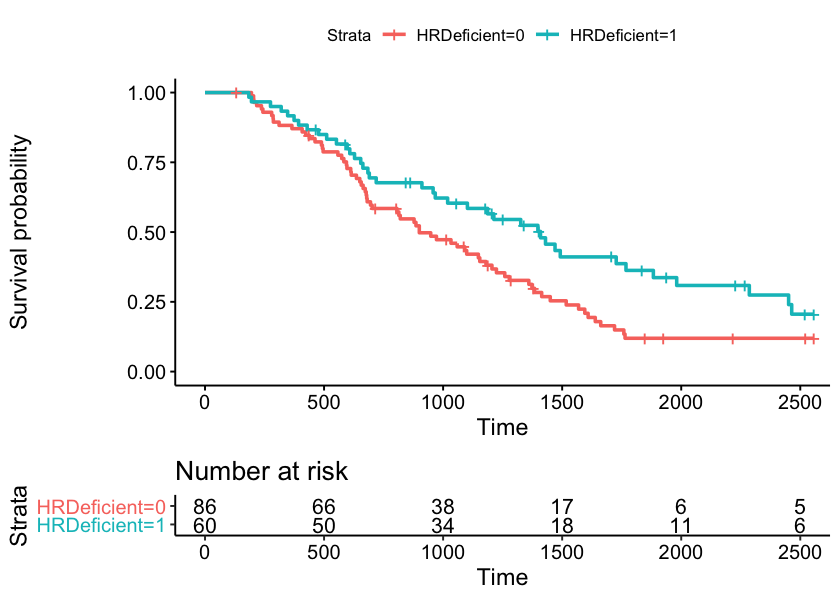

In [49]:
options(repr.plot.height=5,repr.plot.width=7)
gg3<-ggsurvplot(fit_censored,data=censored,risk.table=T)

options(repr.plot.height=5,repr.plot.width=7)
annotate("text",x=2100,y=0.85,label="HR= 0.62 (0.41 - 0.94),\nCoxph p-value=0.024.\nStratified by cohort and\nadjusted for age and stage\nat diagnosis.")+
xlab("Time (days)")+scale_colour_manual(name="HRD status",values=c("#984EA3","#4DAF4A"),labels=c("HR proficient","HR deficient"))+
ylab("Overall survival probability")+ggtitle("OS excluding patients with GSV/SSV at BRCA1/2")
gg3_km

print(gg3,surv.plot.height=0)

## Progression-free survival analysis

### Model

In [50]:
mod<-coxph(Surv(clinical_withdat_sampleinfo_nobrca$donor_relapse_interval,
                clinical_withdat_sampleinfo_nobrca$pfs_event)~clinical_withdat_sampleinfo_nobrca$HRDetect+
           strata(as.factor(clinical_withdat_sampleinfo_nobrca$cohort)))

mod2<-coxph(Surv(clinical_withdat_sampleinfo_nobrca$donor_relapse_interval,
                 clinical_withdat_sampleinfo_nobrca$pfs_event)~as.factor(clinical_withdat_sampleinfo_nobrca$HRDeficient)+
          clinical_withdat_sampleinfo_nobrca$donor_age_at_diagnosis+
                     clinical_withdat_sampleinfo_nobrca$stage+
                     strata(as.factor(clinical_withdat_sampleinfo_nobrca$cohort)))

mod_age_stage<-coxph(Surv(clinical_withdat_sampleinfo_nobrca$donor_relapse_interval,
                          clinical_withdat_sampleinfo_nobrca$pfs_event)~clinical_withdat_sampleinfo_nobrca$HRDetect+
                     clinical_withdat_sampleinfo_nobrca$donor_age_at_diagnosis+
                     clinical_withdat_sampleinfo_nobrca$stage+
                     strata(as.factor(clinical_withdat_sampleinfo_nobrca$cohort)))

In [ ]:
summary(mod)
summary(mod2)
summary(mod_age_stage)


In [55]:
censored<-clinical_withdat_sampleinfo_nobrca
censored$event<-censored$pfs_event
censored$surv_time<-censored$donor_relapse_interval
censored[which(censored$donor_relapse_interval>2557),"event"]<-0
censored[which(censored$donor_relapse_interval>2557),"surv_time"]<-2557
fit_censored <- survfit(Surv(surv_time,event) ~ HRDeficient,data=censored)

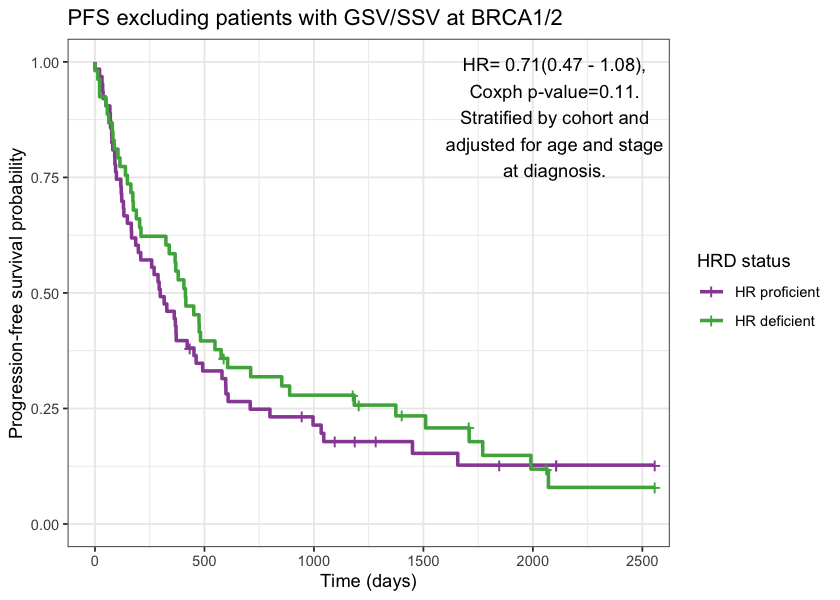

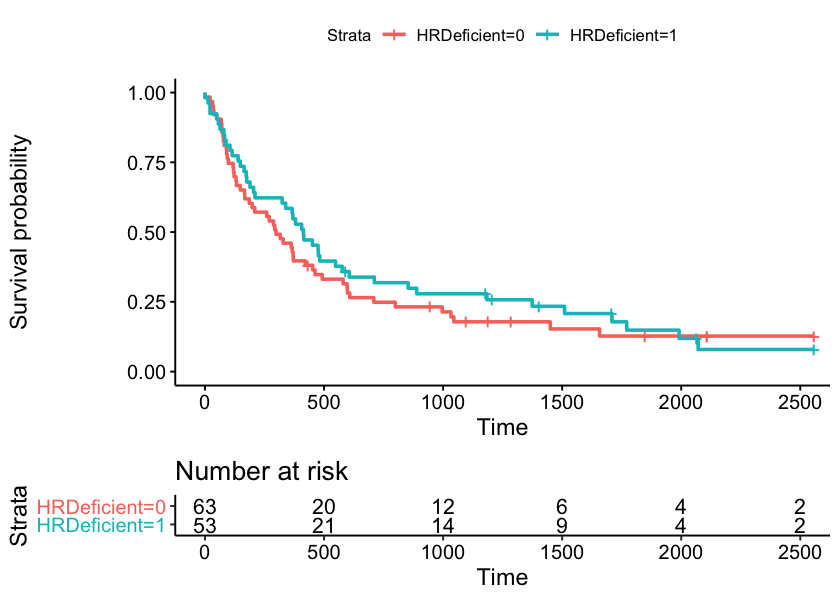

In [58]:
gg4<-ggsurvplot(fit_censored,data=censored,risk.table=T)

options(repr.plot.height=5,repr.plot.width=7)

gg4_km<-gg4$plot + theme_bw()+
annotate("text",x=2100,y=0.88,label="HR= 0.71(0.47 - 1.08),\nCoxph p-value=0.11.\nStratified by cohort and\nadjusted for age and stage\nat diagnosis.")+
xlab("Time (days)")+
scale_colour_manual(name="HRD status",values=c("#984EA3","#4DAF4A"),labels=c("HR proficient","HR deficient"))+
ylab("Progression-free survival probability")+ggtitle("PFS excluding patients with GSV/SSV at BRCA1/2")
gg4_km


gg4

# Combine all plots

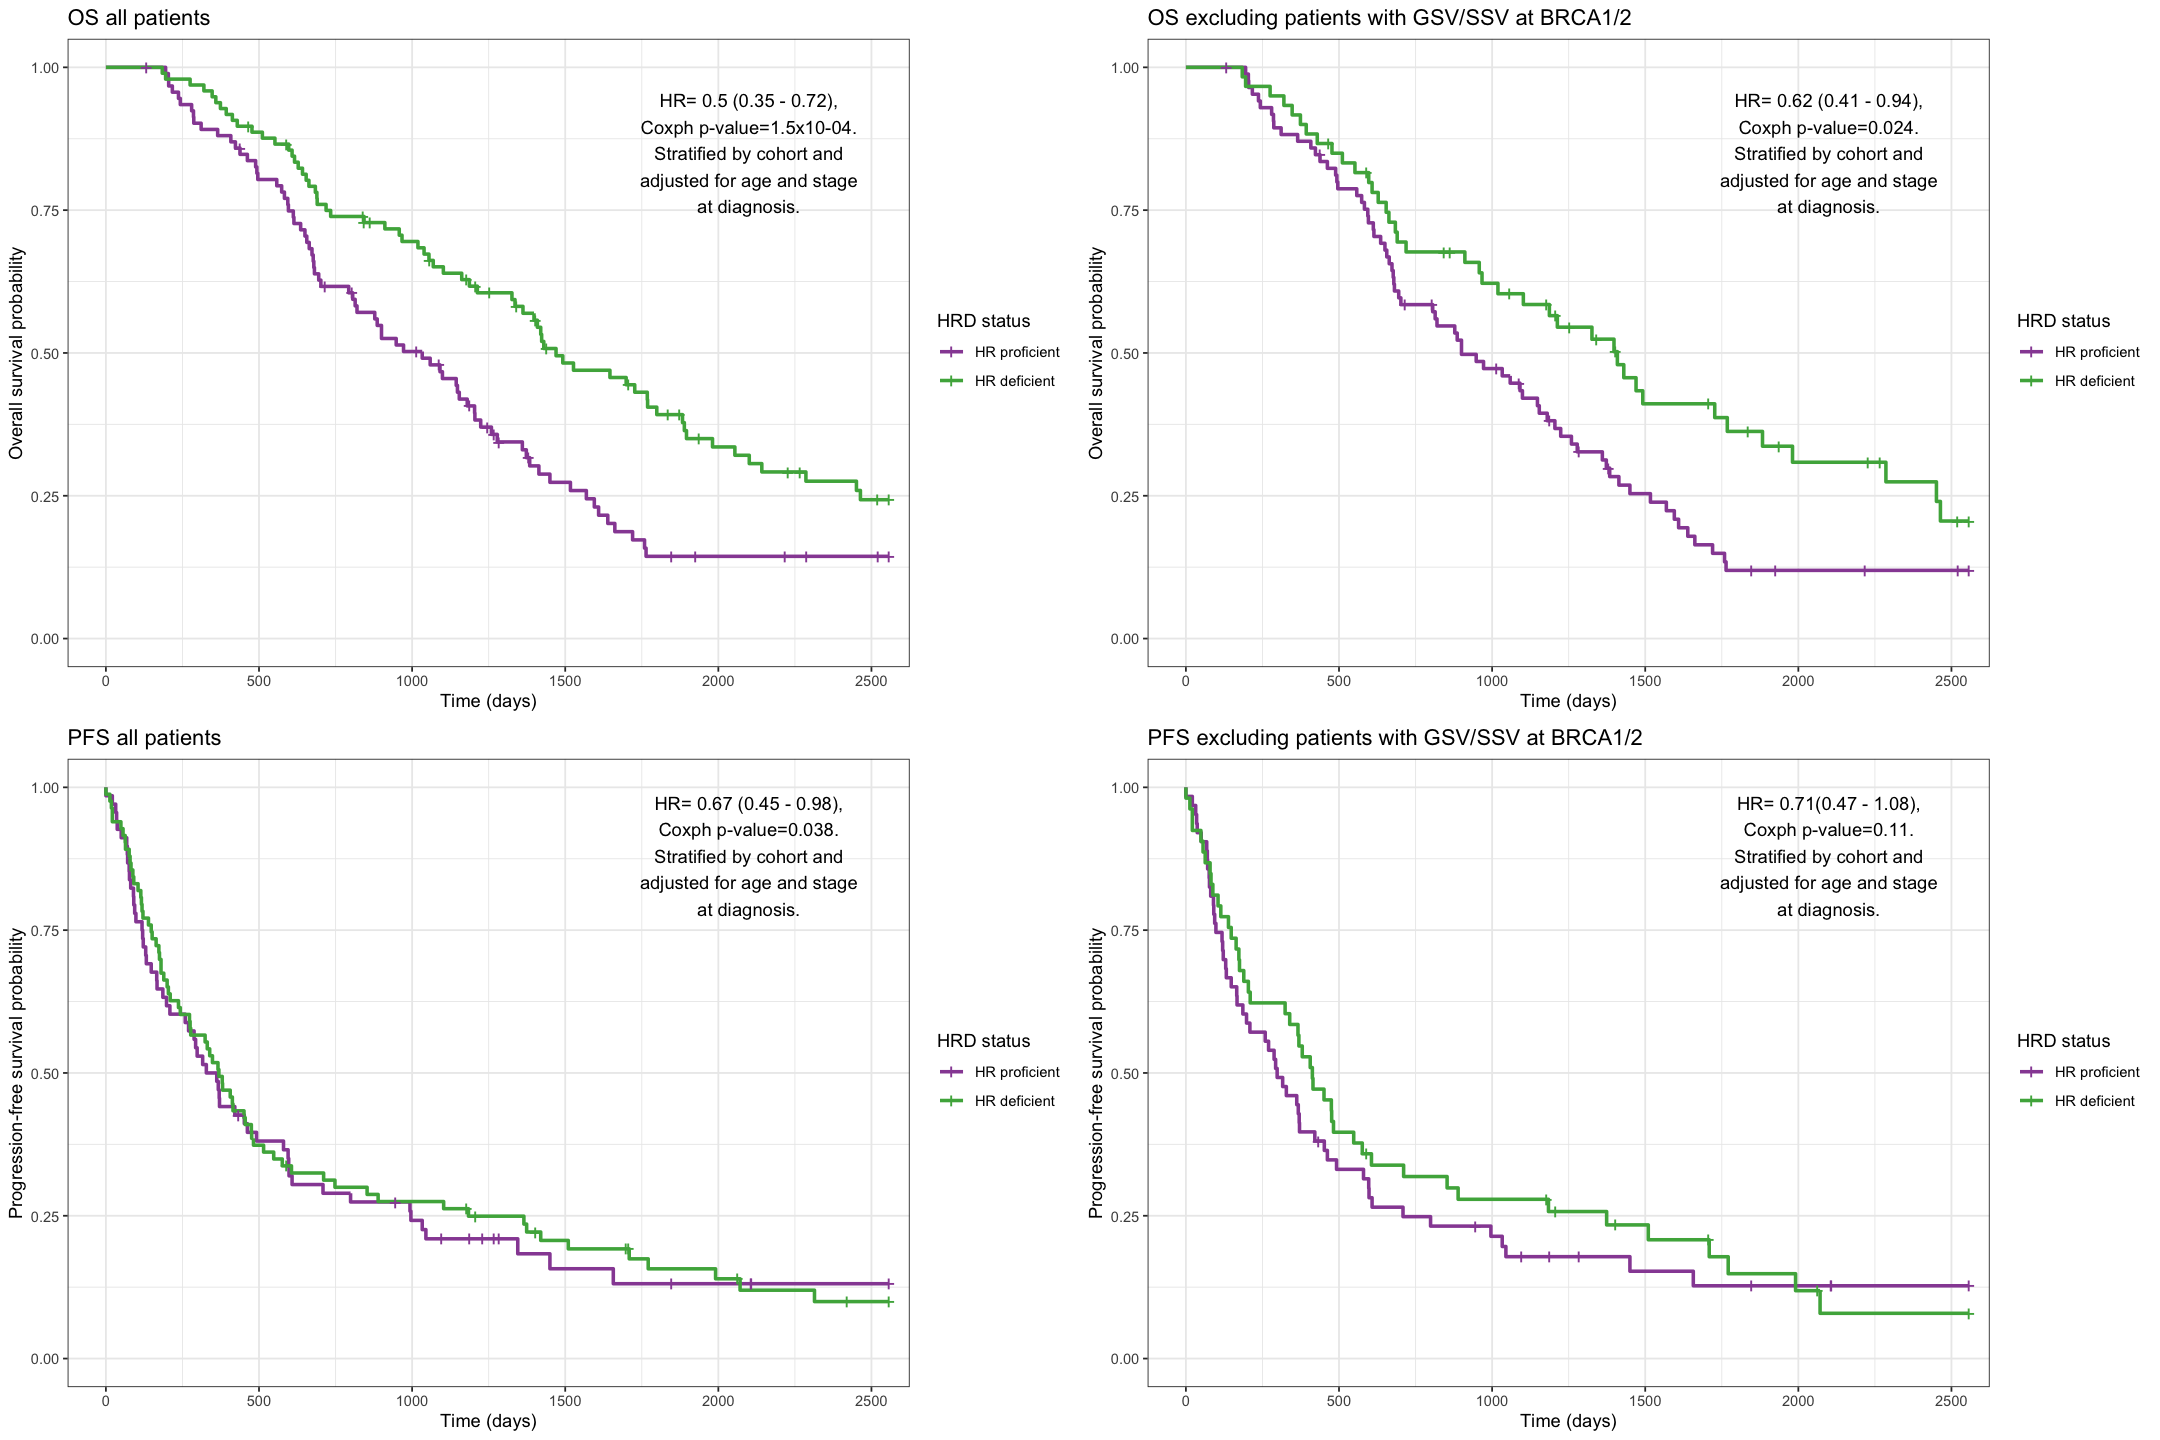

In [67]:
library(gridExtra)
options(repr.plot.width=18
        ,repr.plot.height=12)
#png("~/Desktop/BRCA1_BRCA2_SVs_paper/Manuscript/Intermediate_figures/OS_PFS_survival_figures.png",width=18,height=12,unit="in",res=300)
grid.arrange(gg1_km,gg3_km,gg2_km,gg4_km)
#dev.off()